<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/project%5CKalman_Filters_for_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
#!pip install pykalman
#!pip install yfinance
#!pip install pandas-ta==0.2.45b

In [85]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

[*********************100%***********************]  1 of 1 completed


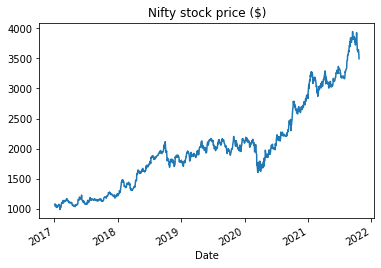

In [86]:
#ticker= yf.Ticker('TSLA')
nifty_df = yf.download('tcs.ns',start='2017-01-01')
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [87]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [88]:
df = nifty_df[['Adj Close']]


mean 3280.8067965958203


Text(0.5, 0, 'Days')

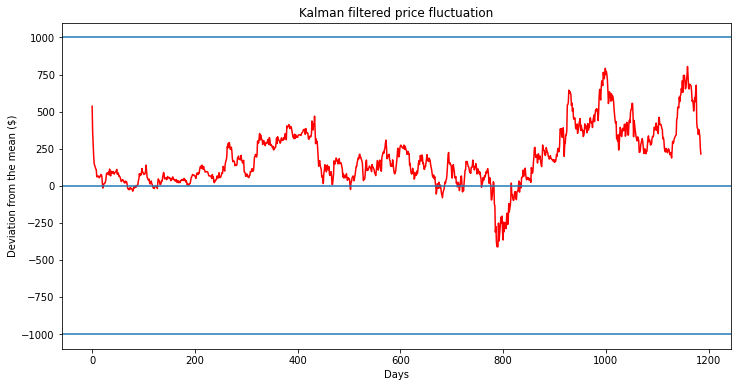

In [89]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')


plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [90]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [91]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(append=True)

print()

In [92]:
nifty

,date,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,2017-01-02,536.085388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-03,359.454918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-04,273.392687,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-05,202.302591,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-06,148.504647,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1181,2021-10-18,378.016919,557.362682,115.315865,615.020614,499.704749,-56.658518,-31.145235,-25.513284
1182,2021-10-19,361.384955,542.806022,120.911452,603.261748,482.350296,-62.072138,-29.247083,-32.825054
1183,2021-10-20,332.741061,525.192675,124.704554,587.544952,462.840398,-67.891186,-28.052905,-39.838281
1184,2021-10-21,253.839841,504.014594,133.173396,570.601292,437.427896,-77.970694,-30.505931,-47.464763


In [93]:
nifty=nifty.set_index('date')

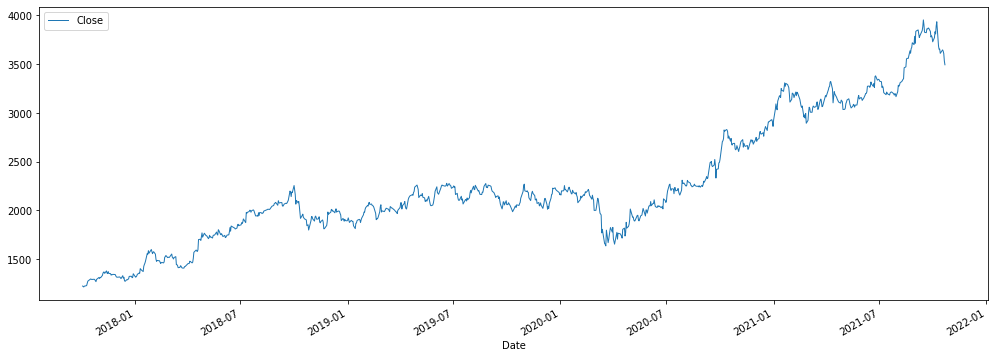

In [100]:
nifty_df[['Close']][-1000:].plot(figsize=(17,6),linewidth=1);

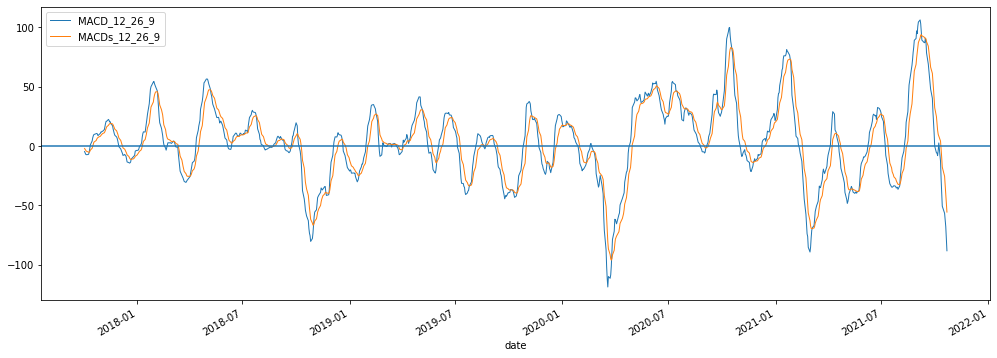

In [102]:
nifty[['MACD_12_26_9','MACDs_12_26_9']][-1000:].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0)